# Reducing the dimensions of image data

## Principal component analysis(PCA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [3]:
df = pd.DataFrame(
    {
        'x1': np.random.normal(loc=10.0, scale=5.0, size=8),
        'noise': np.random.normal(loc=0.0, scale=1.0, size=8),
    }
)

df['x2'] = 3 * df['x1'] + df['noise'] 

df[['x1', 'x2']]

,x1,x2
0,10.726601,30.860859
1,3.663418,10.249158
2,14.673039,45.150732
3,2.247371,6.256914
4,6.387537,17.232989
5,6.630759,17.708560
6,7.492963,21.918856
7,13.434857,39.937677


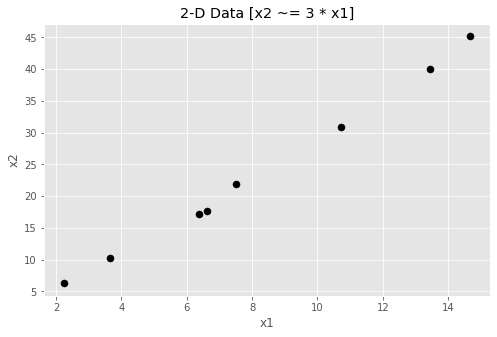

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

df.plot(
    title='2-D Data [x2 ~= 3 * x1]',
    kind='scatter', x='x1', y='x2', ax=ax, color='k', s=50
)

fig.show()


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler(with_std=False)

x = scaler.fit_transform(df[['x1', 'x2']])
# x = df[['x1', 'x2']]

pca = PCA(n_components=1)

pca.fit_transform(x)

array([[  7.63717849],
       [-14.14664397],
       [ 22.44990447],
       [-18.38054565],
       [ -6.66477348],
       [ -6.13768884],
       [ -1.86497825],
       [ 17.10754722]])

In [6]:
pca.explained_variance_

array([211.21906366])

In [7]:
pca.components_

array([[0.30489032, 0.95238747]])

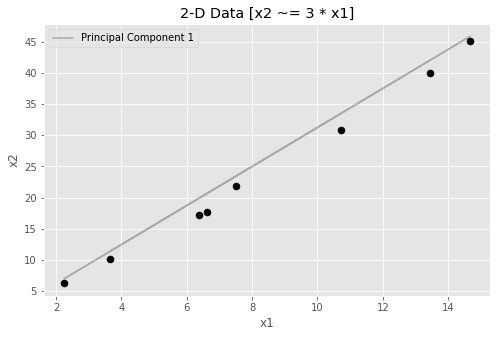

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

df.plot(
    title='2-D Data [x2 ~= 3 * x1]',
    kind='scatter', x='x1', y='x2', ax=ax, color='k', s=50
)

c1_slope = pca.components_[0][1] / pca.components_[0][0]
c1 = np.array([
    [x1, x1 * c1_slope]
    for x1 in df['x1'].values
])
ax.plot(c1[:,0], c1[:,1], '-k', alpha=0.25, label='Principal Component 1')

ax.legend()

fig.show()

In [9]:
from sklearn.datasets import load_digits

digits = load_digits()
digits['data'].min(), digits['data'].max()

def display_img(img, target, ax):
    img = img.reshape((8, 8))
    
    ax.imshow(img, cmap='gray',)
    ax.set_title(f'Digit: {str(target)}')
    ax.grid(False)

In [10]:
from sklearn.model_selection import train_test_split

x, y = digits['data'], digits['target']

x_train, x_test, y_train, y_test = train_test_split(x, y)

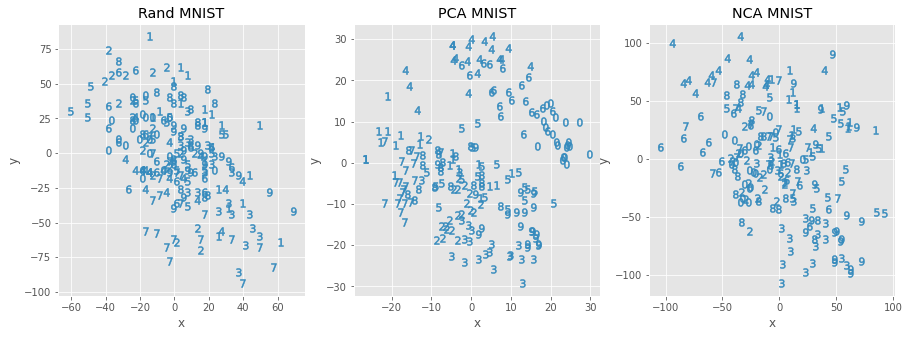

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA
from sklearn.neighbors import NeighborhoodComponentsAnalysis

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

methods = {
 'Rand': SparseRandomProjection(n_components=2),
 'PCA': PCA(n_components=2),
 'NCA': NeighborhoodComponentsAnalysis(n_components=2, init='random'),
}

for i, (method_name, method_obj) in enumerate(methods.items()):
 
    scaler = StandardScaler(with_std=False)
    x_train_scaled = scaler.fit_transform(x_train)
 
    method_obj.fit(x_train_scaled, y_train)
    x_train_2d = method_obj.transform(x_train_scaled)
 
    for target in set(y_train):
        pd.DataFrame(
            x_train_2d[
                y_train == target
            ], columns=['y', 'x']
        ).sample(n=20).plot(
            kind='scatter', x='x', y='y', 
            marker=f'${target}$', s=64, ax=axs[i]
        )
        axs[i].set_title(f'{method_name} MNIST')

fig.show()

In [17]:
import sys
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.manifold import LocallyLinearEmbedding

from sklearn.manifold import MDS

n_components = 6

methods = {
    'Rand': SparseRandomProjection(n_components=n_components),
    'PCA': PCA(n_components=n_components),
    'NCA': NeighborhoodComponentsAnalysis(n_components=n_components, init='pca',),
}

for i, (method_name, method_obj) in enumerate(methods.items()):
    
    scaler = StandardScaler(with_std=False)

    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.fit_transform(x_test)
    
    method_obj.fit(x_train_scaled, y_train)
    x_train_2d = method_obj.transform(x_train_scaled)
    x_test_2d = method_obj.transform(x_test_scaled)

    scaler = MinMaxScaler()

    x_train_scaled = scaler.fit_transform(x_train_2d)
    x_test_scaled = scaler.transform(x_test_2d)

    parameters = {'metric':('manhattan', 'euclidean', 'cosine'), 'n_neighbors': range(3, 9)}

    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, param_grid=parameters, scoring='accuracy', cv=5)

    clf.fit(x_train_scaled, y_train)

    y_test_pred = clf.predict(x_test_scaled)
    
    print(
        'MNIST test accuracy score: {:.1%} [k={}, metric={}, memory footprint={} - {}]'.format(
            accuracy_score(y_test, y_test_pred), 
            clf.best_params_['n_neighbors'], 
            clf.best_params_['metric'], 
            sys.getsizeof(pickle.dumps(clf)),
            method_name
        )

    )

MNIST test accuracy score: 72.7% [k=6, metric=euclidean, memory footprint=164391 - Rand]
MNIST test accuracy score: 90.9% [k=5, metric=euclidean, memory footprint=99677 - PCA]
MNIST test accuracy score: 92.7% [k=4, metric=euclidean, memory footprint=99677 - NCA]


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler(with_std=False)

pca = PCA()

x_train_scaled = scaler.fit_transform(x_train)
pca.fit(x_train_scaled)

df_explained_variance_ratio = pd.DataFrame(
    [
        (component, explained_variance_ratio) 
        for component, explained_variance_ratio in enumerate(pca.explained_variance_ratio_[:32], 1)
    ],
    columns=['component', 'explained_variance_ratio']
)

In [22]:
df_explained_variance_ratio

,component,explained_variance_ratio
0,1,0.143562
1,2,0.137030
2,3,0.121362
3,4,0.086446
4,5,0.057361
5,6,0.048827
6,7,0.044078
7,8,0.036736
8,9,0.031898
9,10,0.030758


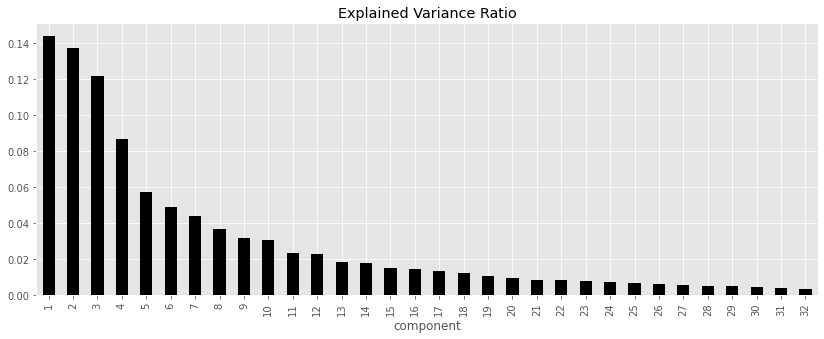

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))

df_explained_variance_ratio.set_index('component')['explained_variance_ratio'].plot(
    title='Explained Variance Ratio',
    kind='bar',
    color='k',
    ax=ax
)

fig.show()

In [24]:
from sklearn.neighbors import NearestCentroid

clf = NearestCentroid()

clf.fit(x_train, y_train)

y_test_pred = clf.predict(x_test)

print(
    'MNIST test accuracy score: {:.1%}'.format(
        accuracy_score(y_test, y_test_pred), 
    )

)

MNIST test accuracy score: 90.7%


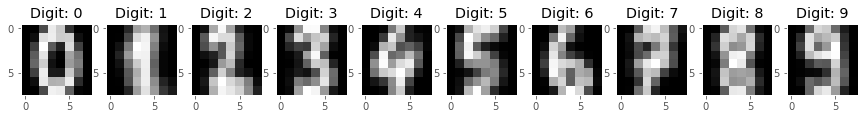

In [25]:
fig, axs = plt.subplots(1, len(clf.classes_), figsize=(15, 5))

for i, (centroid, label) in enumerate(zip(clf.centroids_, clf.classes_)):
    display_img(centroid, label, axs[i])
    
fig.show()

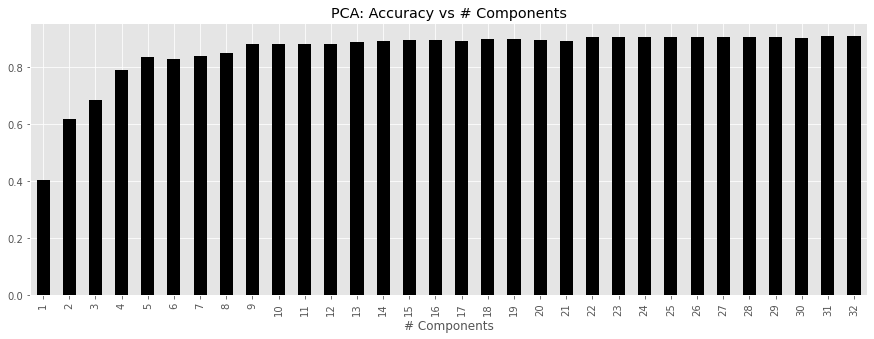

In [26]:
from sklearn.neighbors import NearestCentroid

scores = []

for n_components in range(1, 33, 1):
    
    scaler = StandardScaler(with_std=False)
    embedder = PCA(n_components=n_components)
    
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    clf = NearestCentroid(shrink_threshold=0.01)

    embedder.fit(x_train_scaled, y_train)
    x_train_embed = embedder.transform(x_train_scaled)
    x_test_embed = embedder.transform(x_test_scaled)

    clf.fit(x_train_embed, y_train)

    y_test_pred = clf.predict(x_test_embed)

    scores.append([n_components, accuracy_score(y_test, y_test_pred)])
    

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

pd.DataFrame(
    scores,
    columns=['# Components', 'Accuracy']
).set_index(
    '# Components'
)['Accuracy'].plot(
    title='{}: Accuracy vs # Components'.format(str(embedder).split('(')[0]),
    kind='bar',
    color='k',
    ax=ax
)

fig.show()